In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt

%matplotlib inline 


import random

In [31]:
class RBF_Net(object):
    def __init__(self):
        return 
        
    def fit(self, X_train, Y_train, C):
        self.X = X_train
        self.Y = Y_train.T
        self.C = C
        
        self.d = self.d_constr(self.C)
        self.F = self.F_constr(self.X, self.C, self.d)
        #self.F = self.F_mah_constr(self.X, self.C, self.d)
        self.Wb = self.train(self.Y, self.F)
        
        self.y_dim = len(Y_train[0])
        self.x_dim = len(X_train[0])

    def d_constr(self, C):
        N = len(C)
        d = np.zeros(N)
        l = np.zeros(N)
        
        for i in tqdm(range(N),"Distant progress"):
            for j in range(N):
                l[j] = np.linalg.norm(C[i] - C[j])
            d[i] = np.std(l) 
        return d

    def F_constr(self, X, C, d):
        S = len(X)
        N = len(C)
        
        F = np.zeros((N, S))
        for i in tqdm(range(N),"F progress"):
            for j in range(S):
                F[i][j] = np.linalg.norm(X[j] - C[i])
            F[i] = F[i] / d[i]
        F = np.exp(-(F ** 2))
        return F
    
    def F_mah_constr(self, X, C, d):
        S = len(X)
        N = len(C)
        F = np.zeros((N, S))
        Z = np.cov(X.T)
        
        Z = tf.linalg.pinv(Z, rcond = 10**(-100), validate_args = True)
        
        Z = tf.make_tensor_proto(Z)
        Z = tf.make_ndarray(Z)
        
        for i in tqdm(range(N),"F progress"):
            for j in range(S):
                v = np.reshape(X[j] - C[i],(1,-1))
                vv = np.dot(v, Z)
                F[i][j] = np.dot(vv, v.T)
        return F
        
    def FA_const(self, F):
        a = np.ones((1, len(F[0])))
        return np.vstack((F, a))
        
    def train(self, Y, F):
        FA = self.FA_const(F)
        
        FAFAT =tf.linalg.matmul(FA, FA, transpose_b=True)

        self.mu = np.linalg.cond(tf.make_ndarray(tf.make_tensor_proto(FAFAT)))
        FAFAT = tf.linalg.pinv(FAFAT, rcond = 10**(-100), validate_args = True)
        
        Wb =  tf.linalg.matmul(Y, FA, transpose_b=True)
        Wb =  tf.linalg.matmul(Wb, FAFAT)

        #YY = tf.linalg.matmul(Wb, FA)
        
        Wb = tf.make_tensor_proto(Wb)
        Wb = tf.make_ndarray(Wb)
        
        print('Train complete')
        
        return Wb
        
        
        
    def predict(self, X):
        F = self.F_constr(X, self.C, self.d)
        FA = self.FA_const(F)
        Y_pr = np.dot(self.Wb, FA)
        return Y_pr.T       
    pass

In [3]:
def weighting(X, func_type):

    if func_type == 'sin':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)
        return X*weight

    if func_type == 'sin^2':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)**2
        return X*weight

    if func_type == 'sin^4':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)**4
        return X*weight

    if func_type == '1-log':
        return 1 - (X[:,0:1] ** 2 + X ** 2) / 10

    if func_type == 'log':
        return np.log(X)

    if func_type == 'm_func':
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.copy(angles)
        for i in range(len(angles)):
            if i == 0:
                weight[i] = 0
            if (i > 0) and (i < 90):
                weight[i] = (np.exp(-2*(np.log(i/54.0))**2))/i
            
            if (i > 90):
                weight[i] = weight[181-i]

        return X * weight

def cutter(X, start, end):
    return X[:,start:end+1]

In [4]:
def predict_plot(y_test, y_pred, params):
    N = len(params)
    
    plt.figure(figsize=(20,20))
    
    for i in range (N):
        for j in range(N):
            plt.subplot(N, N, i*N+j+1)

            plt.title("Предсказание с помощью сетей")
            plt.xlabel(params[i])
            plt.ylabel(params[j])

            plt.plot(y_test[:,i], y_test[:,j] ,'*', label = "Тест")
            plt.plot(y_pred[:,i], y_pred[:,j], '.', label = "Предсказание")
            plt.legend()


def error_plot(y_test, y_pred, params):
    
    N = len(params)
    
    error = []
    for j in range(len(y_pred[0])):
        buf_err = []    
        for i in range(len(y_pred)):
            buf_err.append((y_test[i,j]-y_pred[i,j]))   
        error.append(buf_err)


    plt.figure(figsize=(20,20))
    
    for i in range (N):
        
        plt.subplot(N, 2, i*2+1)
        plt.title("Ошибка предсказания %s" %(params[i]))
        plt.ylabel("Ошибка предсказания %s" %(params[i]))
        plt.xlabel("Номер индикатрисы")
        plt.plot(error[i],'*')
        
    
        plt.subplot(N, 2, i*2+2)
        plt.title("Распределение ошибки %s" %(params[i]))
        plt.xlabel("Ошибка предсказания %s" %(params[i]))
        plt.hist(error[i], 100)
        plt.text(0,0,'mu = %f \n sigma = %f' %(np.mean(error[i]),np.std(error[i])),bbox=dict(facecolor='white'))

    return error

In [5]:
col_list = ['r' ,'n']
for i in range(181):
    col_list.append(str(i))

df = pd.read_csv('spheres', delimiter = '\t', names = col_list)
df_test = pd.read_csv('random_spheres', delimiter = '\t', names = col_list)

In [6]:
y_train = np.array(df)[:, :2]
x_train = (np.array(df)[:,2:])

y_test = np.array(df_test)[:, :2]
x_test = (np.array(df_test)[:,2:])

x_train = weighting(x_train, 'm_func')
x_test = weighting(x_test, 'm_func')

x_train = cutter(x_train, 10 , 70)
x_test = cutter(x_test, 10 , 70)

In [7]:
C = np.copy(x_train)

In [33]:
rbf = RBF_Net()
rbf.fit(x_train, y_train, C)
y_pred = rbf.predict(x_test)

F progress: 100%|██████████████████████████| 2000/2000 [00:36<00:00, 54.90it/s]


Train complete


F progress: 100%|██████████████████████████| 2000/2000 [03:04<00:00, 10.84it/s]


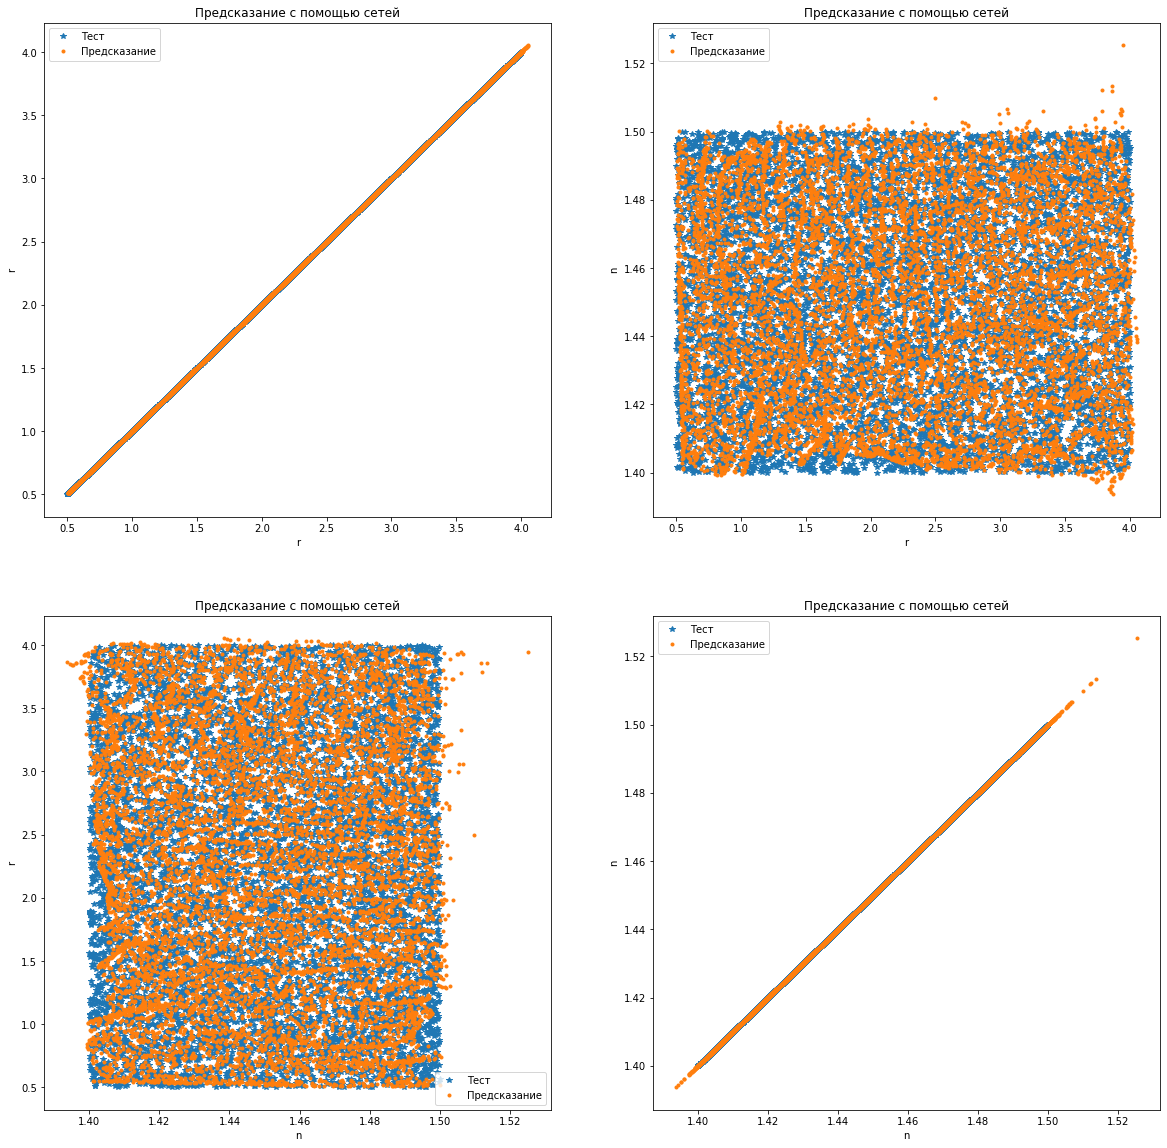

In [34]:
predict_plot(y_test, y_pred, ['r','n'])

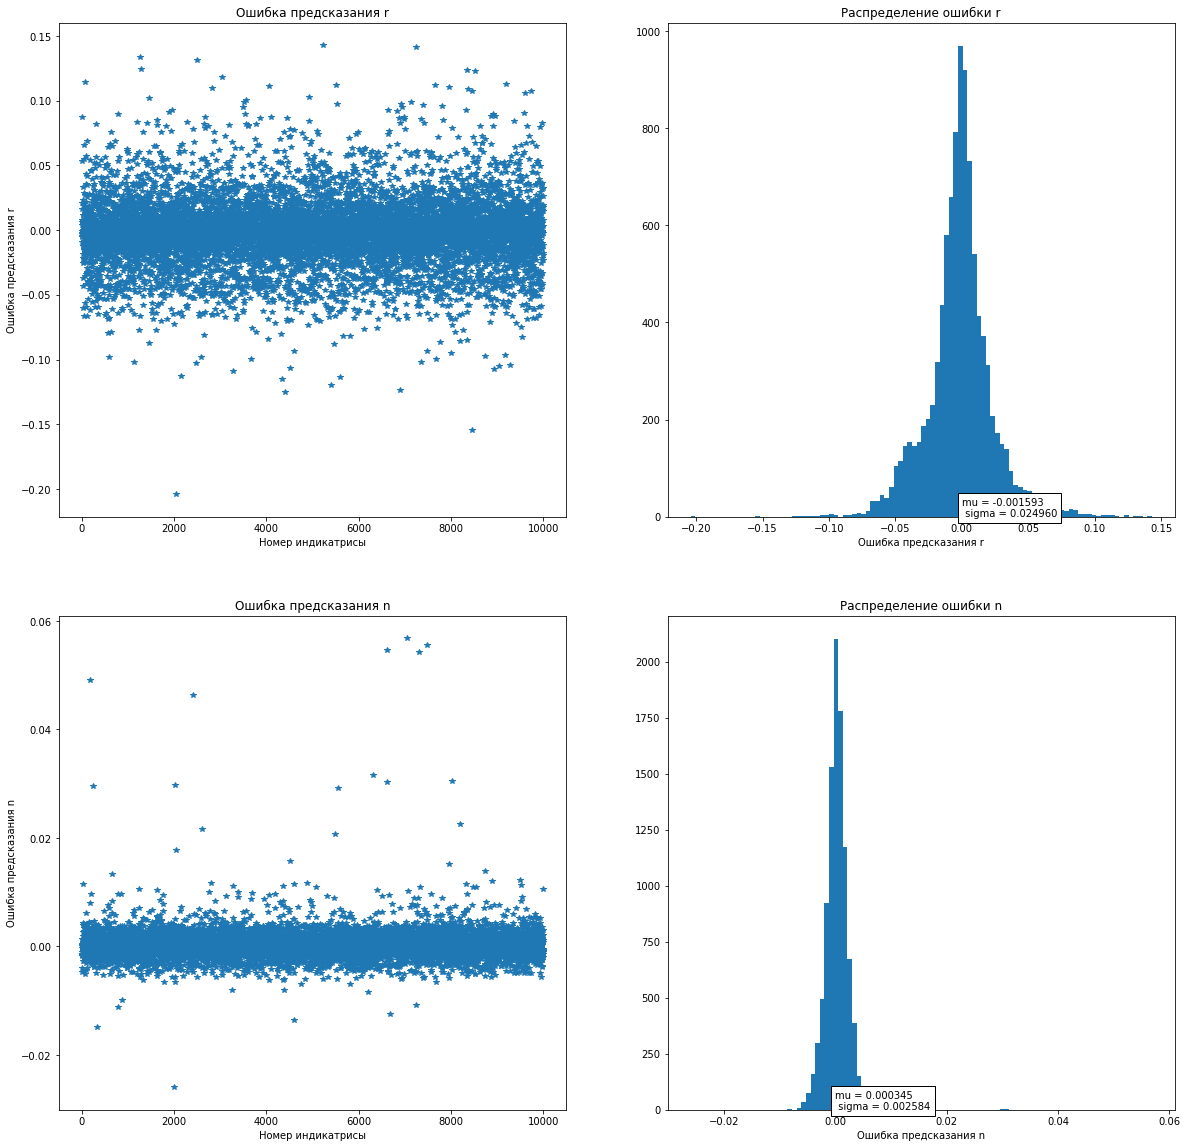

In [35]:
errors = error_plot(y_test, y_pred,['r','n'])

In [36]:
x_test_noise = np.copy(x_test)
for i in range(len(x_test_noise)):
    sigma = np.max((x_test_noise[i])) * 0.03
    for j in range(len(x_test_noise[i])):
        x_test_noise[i][j] = np.random.normal(x_test_noise[i][j], sigma)

In [37]:
y_pred_noise = rbf.predict(x_test_noise)

F progress: 100%|██████████████████████████| 2000/2000 [03:04<00:00, 10.84it/s]


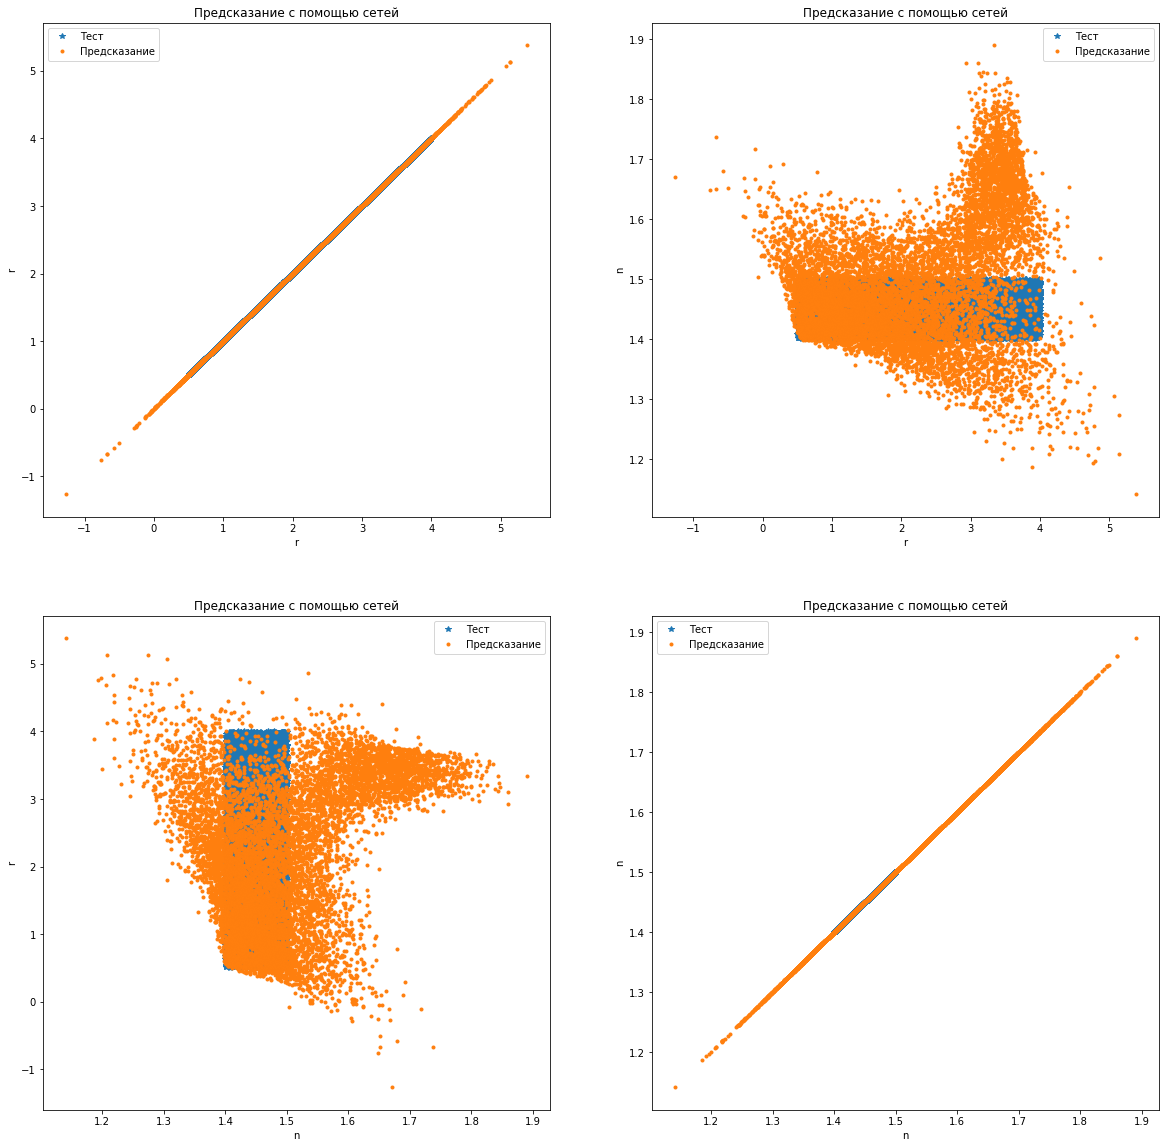

In [38]:
predict_plot(y_test, y_pred_noise, ['r','n'])

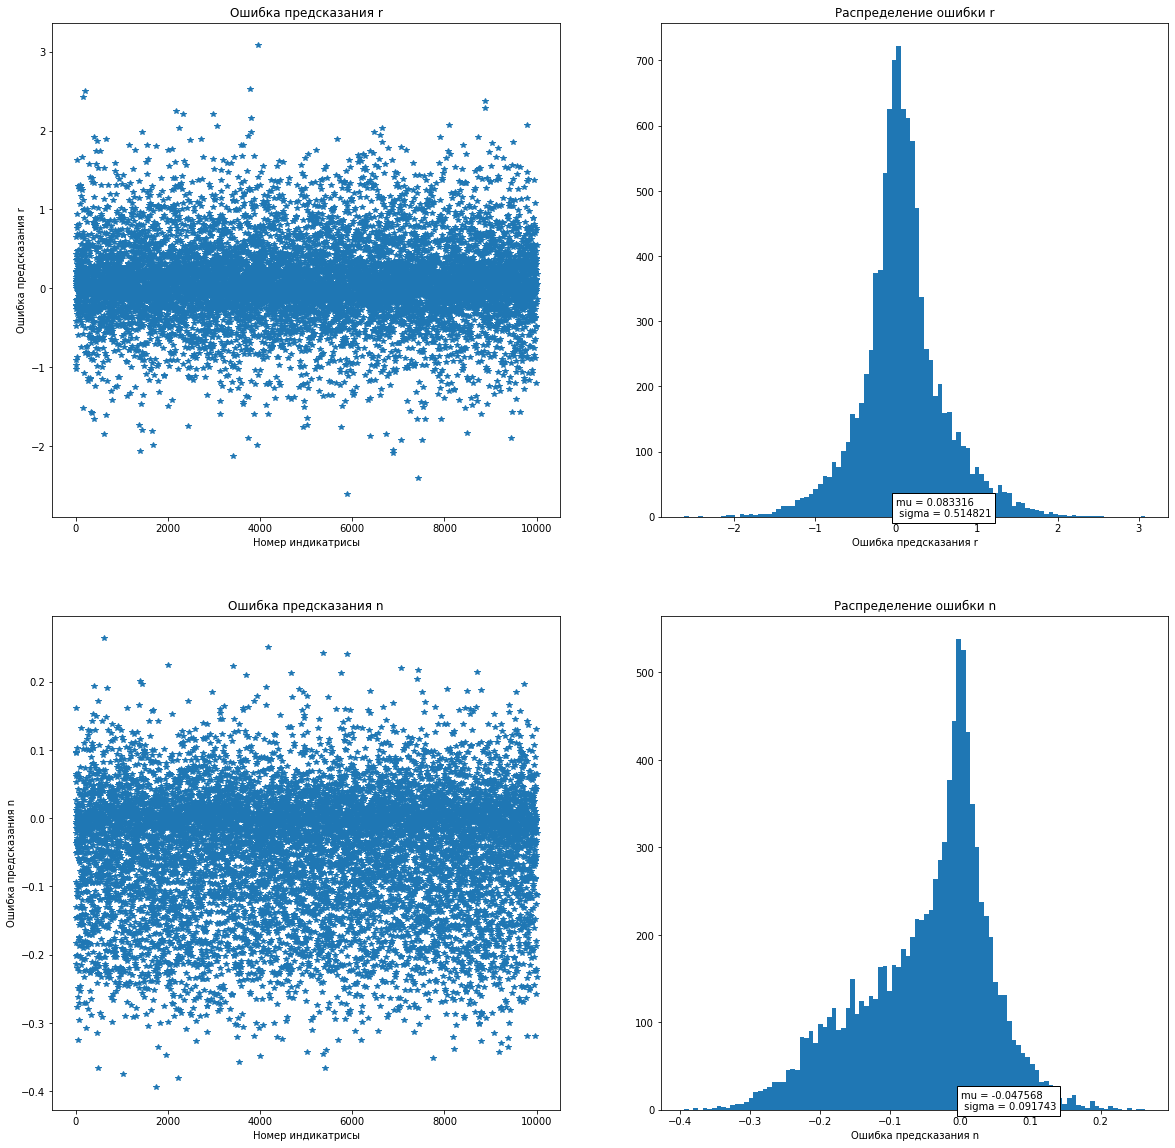

In [39]:
errors = error_plot(y_test, y_pred_noise,['r','n'])

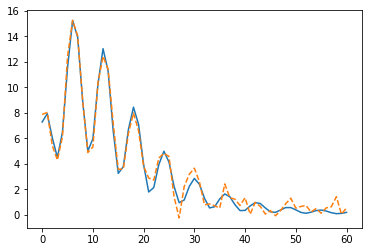

In [40]:
plt.plot(x_test[1],'-',x_test_noise[1],'--')

In [32]:
del rbf